<a href="https://colab.research.google.com/github/PuchToTalk/LLM/blob/Bert/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONVEX FINETUNING - Sentiment analysis**

It is a Python script for a machine learning workflow that appears to be focused on fine-tuning an embedding model for sentiment analysis

Here's a brief overview of what the script does:

1.   Load data(Here, complaints are labelled as 1, non-complaints are labelled as 0)

2.   Finetune a 1, 2-layer network with the pre-trained embedding

3.   Finetune a convex network with the pre-trained embedding

4.   Compare the speed, accuracy(plot the loss curve, test accuracy, training accuracy)

The codes are based on a BERT tutorial https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

**1. UPLOADING DATA**

In [1]:
!pip install transformers
!pip install pyscnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.0/123.0 kB 3.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
notebook_path = '/content/drive/My Drive/Stanford_Research/Work/Convex-Optimization/'
data_path = '/content/drive/My Drive/Stanford_Research/Work/Convex-Optimization/data/'

In [4]:
%cd $notebook_path

/content/drive/My Drive/Stanford_Research/Work/Convex-Optimization


In [5]:
import os
import re
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
 # Load data and set labels
data_complaint = pd.read_csv('data/complaint1700.csv')
data_complaint['label'] = 1
data_non_complaint = pd.read_csv('data/noncomplaint1700.csv')
data_non_complaint['label'] = -1

# Concatenate complaining and non-complaining data
data = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)

# Drop 'airline' column
data.drop(['airline'], inplace=True, axis=1)

# Display 5 random samples
data.sample(5)

,id,tweet,label
2692,94657,@Ali_Sweeney @AmericanAir Nice....we miss you,-1
2150,37594,"You are no longer my boy, Blue. http://t.co/aI...",-1
2729,98283,After almost 20k miles flying with @AlaskaAir ...,-1
1095,81736,"@AmericanAir so, so tired of the bait/switch ""...",1
311,15195,@AmericanAir has been cancelling flights from ...,1


In [8]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

In [9]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['id', 'tweet']]

# Display 5 samples from the test data
test_data.sample(5)

,id,tweet
1970,76198,"@AmericanAir Hi, I cancelled QMVFNJ more than ..."
1568,60401,@SouthwestAir @AmericanAir @united @Delta : wh...
3297,124907,@Democrats14 @RepSwalwell @united |STREAM OVER...
3654,138225,I hate @AmericanAir this is the 2nd time in 1 ...
3561,134454,Fuck @AlaskaAir straight to hell for kicking a...


In [10]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [11]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Processed:  I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on & check in. Can you help?


In [12]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [13]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  68


In [11]:
# Specify `MAX_LEN`
MAX_LEN = 68

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0],"How are you?"])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

NameError: ignored

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [40]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate a two-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [41]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert = True)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to("cpu")

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

CrossEntropy (2D)

In [18]:
import random
import time
# Specify loss function
loss_fn = nn.CrossEntropyLoss()
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
# Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
# =======================================
#               Training
# =======================================
# Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
# Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()
# Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
# Put the model into the training mode
        model.train()
# For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
# Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)
# Zero out any previously calculated gradients
            model.zero_grad()
# Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
# Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
# Perform a backward pass to calculate gradients
            loss.backward()
# Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
# Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
# Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
# Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
# Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
# Reset batch tracking variables
            batch_loss, batch_counts = 0, 0
            t0_batch = time.time()
# Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
# =======================================
#               Evaluation
# =======================================
    if evaluation == True:
# After the completion of each training epoch, measure the model's performance
# on our validation set.
        val_loss, val_accuracy = evaluate(model, val_dataloader)
# Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        print("-"*70)
    print("\n")
    print("Training complete!")
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
# Put the model into the evaluation mode. The dropout layers are disabled during
# the test time.
    model.eval()
# Tracking variables
    val_accuracy = []
    val_loss = []
# For each batch in our validation set...
    for batch in val_dataloader:
# Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)
# Compute logits
    with torch.no_grad():
        logits = model(b_input_ids, b_attn_mask)
# Compute loss
    loss = loss_fn(logits, b_labels)
    val_loss.append(loss.item())
# Get the predictions
    preds = torch.argmax(logits, dim=1).flatten()
# Calculate the accuracy rate
    accuracy = (preds == b_labels).cpu().numpy().mean() * 100
    val_accuracy.append(accuracy)
# Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

Hinge Loss (1D)


In [19]:
import random
import time
# Specify loss function
loss_fn = nn.HingeEmbeddingLoss()


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
# Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
# =======================================
#               Training
# =======================================
# Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
# Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()
# Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
# Put the model into the training mode
        model.train()
# For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
# Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)
# Zero out any previously calculated gradients
            model.zero_grad()
# Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
# Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
# Perform a backward pass to calculate gradients
            loss.backward()
# Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
# Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
# Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
# Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
# Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
# Reset batch tracking variables
            batch_loss, batch_counts = 0, 0
            t0_batch = time.time()
# Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
# =======================================
#               Evaluation
# =======================================
    if evaluation == True:
# After the completion of each training epoch, measure the model's performance
# on our validation set.
        val_loss, val_accuracy = evaluate(model, val_dataloader)
# Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        print("-"*70)
    print("\n")
    print("Training complete!")
# ... [rest of the code above]

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Convert logits to either 1 or -1
        preds = torch.sign(logits).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy




In [55]:
import torch
import torch.nn as nn
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
import numpy as np

# Use the Binary Cross-Entropy loss with Logits
loss_fn = nn.BCEWithLogitsLoss()

class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks."""
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 1

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Classifier with dropout for regularization
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer
            nn.Linear(H, D_out)
        )

        # Optionally, unfreeze BERT layers
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits.squeeze(-1)  # Make sure the logits are of shape [batch_size]

def initialize_model(epochs=4):
    bert_classifier = BertClassifier(freeze_bert=True)

    # Unfreeze the last two layers of BERT
    for param in bert_classifier.bert.encoder.layer[-2:].parameters():
        param.requires_grad = True

    bert_classifier.to("cpu")
    optimizer = AdamW(bert_classifier.parameters(), lr=3e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler
def evaluate(model, val_dataloader):
    model.eval()
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels.float())
        val_loss.append(loss.item())
        preds = torch.round(torch.sigmoid(logits)).float().flatten()  # Ensure preds is of type FloatTensor
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy


In [56]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)

In [ ]:
#train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)
train_losses, val_losses = train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)


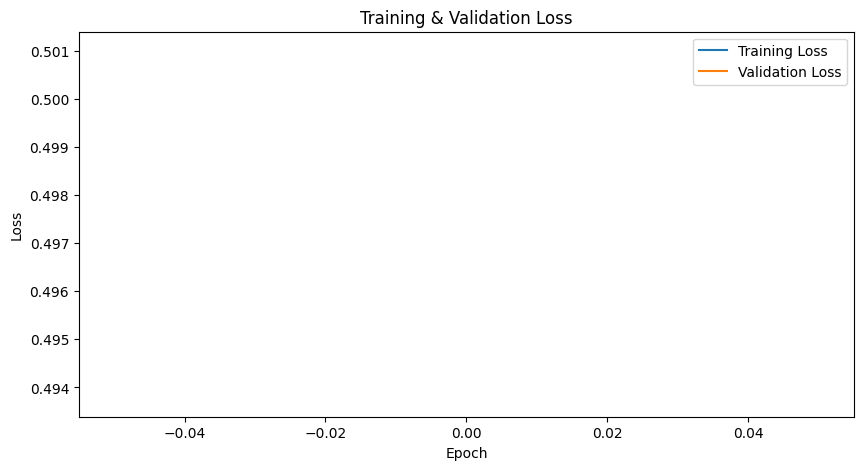

In [39]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**2. Convex Finetuning**

In [ ]:
Pretrained_Bert = BertModel.from_pretrained('bert-base-uncased')
last_hidden_state_cls = np.zeros((0,768))

for i in range(np.shape(train_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=train_inputs[i*20:(i+1)*20], attention_mask=train_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    last_hidden_state_cls = np.concatenate((last_hidden_state_cls, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(last_hidden_state_cls))

In [ ]:
Embedding_Size = 768
max_neurons = 30
num_labels = 2
training_data_np = last_hidden_state_cls
training_labels_np = y_train
training_labels_np[training_labels_np == 0] = -1
n = np.shape(training_data_np)[0]

batch_size = n//10

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return x>=0

beta = 1e-3
learned_U1 = []
learned_U2 = []

for u in range(n//batch_size):

    training_batch_data_np = training_data_np[u*batch_size:(u+1)*batch_size]
    training_batch_labels_np = training_labels_np[u*batch_size:(u+1)*batch_size]

    G = np.random.randn(Embedding_Size,max_neurons)
    dmat= drelu(np.matmul(training_batch_data_np,G))

    # Optimal CVX
    m1=dmat.shape[1]
    Uopt1=cp.Variable((Embedding_Size,m1))
    Uopt2=cp.Variable((Embedding_Size,m1))

    ## Below we use hinge loss as a performance metric for binary classification
    yopt1=cp.Parameter((batch_size,1))
    yopt2=cp.Parameter((batch_size,1))
    yopt1=cp.sum(cp.multiply(dmat,(training_batch_data_np*Uopt1)),axis=1)
    yopt2=cp.sum(cp.multiply(dmat,(training_batch_data_np*Uopt2)),axis=1)
    cost=cp.sum(cp.pos(1-cp.multiply(training_batch_labels_np,yopt1-yopt2)))/n+beta*(cp.mixed_norm(Uopt1.T,2,1)+cp.mixed_norm(Uopt2.T,2,1))
    constraints=[]
    constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt1))>=0]
    constraints+=[cp.multiply((2*dmat-np.ones((batch_size,m1))),(training_batch_data_np*Uopt2))>=0]
    prob=cp.Problem(cp.Minimize(cost),constraints)
    prob.solve()
    cvx_opt=prob.value
    print("Convex program objective value (eq (8)): ",cvx_opt)

    learned_U1.append(Uopt1._value)
    learned_U2.append(Uopt2._value)

In [ ]:
test_data_np = np.zeros((0,768))
for i in range(np.shape(val_inputs)[0]//20):
    outputs = Pretrained_Bert(input_ids=val_inputs[i*20:(i+1)*20], attention_mask=val_masks[i*20:(i+1)*20])
    # Extract the last hidden state of the token `[CLS]` for classification task
    test_data_np = np.concatenate((test_data_np, outputs[0][:, 0, :].squeeze().detach().numpy()))
    print(np.shape(test_data_np))
test_labels_np = y_val
test_labels_np[test_labels_np == 0] = -1

In [ ]:
dmat = drelu(np.matmul(test_data_np,G))
Uopt1_np = np.array(sum(learned_U1)/(n//batch_size))
Uopt2_np = np.array(sum(learned_U2)/(n//batch_size))


preds = np.sum(np.multiply(dmat, np.matmul(test_data_np, Uopt1_np-Uopt2_np)),axis = 1)

preds[preds > 0] = int(1)
preds[preds < 0] = int(-1)

acc = np.sum((preds == test_labels_np))
print("Convex accuacy:"+str(acc/np.shape(test_labels_np)[0]*100)+"%")

**3. Fast Convex Finetuning**

In [ ]:
from scnn.metrics import Metrics
from scnn.models import ConvexGatedReLU
from scnn.activations import sample_gate_vectors
from scnn.solvers import RFISTA
from scnn.optimize import optimize_model

G = sample_gate_vectors(783, Embedding_Size, max_neurons)
W1_list = []
W2_list = []

for u in range(n//batch_size):

    training_batch_data_np = training_data_np[u*batch_size:(u+1)*batch_size]
    training_batch_labels_np = training_labels_np[u*batch_size:(u+1)*batch_size]

    CVXPY_adapter = ConvexGatedReLU(G, c = 2, bias = False)
    #solver = RFISTA(CVXPY_adapter, max_iters = 10000, tol = 1e-6)
    solver = za

    training_labels_np[training_labels_np == -1] = 0
    CVXPY_adapter_trained = optimize_model(CVXPY_adapter, solver, Metrics(), X_train = training_batch_data_np, y_train = training_batch_labels_np)[0]
    W1_list.append(CVXPY_adapter_trained.parameters[0])
    W2_list.append(CVXPY_adapter_trained.parameters[1])


In [ ]:
from scnn.models import NonConvexGatedReLU

CVXPY_adapter_merged = NonConvexGatedReLU(CVXPY_adapter_trained.G, c = 2, bias = False)
CVXPY_adapter_merged.parameters[0] = sum(W1_list)/(n//batch_size)
CVXPY_adapter_merged.parameters[1] = sum(W2_list)/(n//batch_size)

In [ ]:
test_result = CVXPY_adapter_merged(test_data_np)
print(np.argmax(test_result,axis = 1))

**4. Tests**


In [6]:
 # Load data and set labels
data_complaint = pd.read_csv('data/complaint1700.csv')
data_complaint['label'] = 1
data_non_complaint = pd.read_csv('data/noncomplaint1700.csv')
data_non_complaint['label'] = 0

# Concatenate complaining and non-complaining data
data = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)

# Drop 'airline' column
data.drop(['airline'], inplace=True, axis=1)

# Display 5 random samples
data.sample(5)

,id,tweet,label
3258,154544,.@JetBlue What the heck is the last sec change...,0
2505,75643,For the record- I am #upset at @VirginAustrali...,0
706,144715,Really unimpressed with @Delta today. Delayed ...,1
2443,69655,@LetsGetLexi @TheAlfredoPlays @VirginAmerica o...,0
2924,121586,@adventurousness @AmericanAir you can always f...,0


In [7]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

In [12]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['id', 'tweet']]

# Display 5 samples from the test data
test_data.sample(5)

,id,tweet
3268,123953,Im never using @AmericanAir again!!! Waiting a...
3668,138690,Last night was so stressful! My flight got del...
2991,113304,@JetBlue #worstcustomerservice at @NY_NJairpor...
588,23260,@sampottorff @AmericanAir @GOLDENthe24k @Edwar...
4007,152834,"@DeltaAssist 1/ guys, big fan / gold medallion..."


In [13]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [14]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Processed:  I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on & check in. Can you help?


In [15]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [16]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)# Specify `MAX_LEN`



Max length:  68


In [17]:
MAX_LEN = 68

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0],"How are you?"])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Token IDs:  [array([ 101, 1045, 1005, 1049, 2383, 3314, 1012, 7483, 1045, 2128, 8654,
       2098, 2005, 2484, 2847, 2044, 1045, 2001, 4011, 2000, 4875, 1010,
       2085, 1045, 2064, 1005, 1056, 8833, 2006, 1004, 4638, 1999, 1012,
       2064, 2017, 2393, 1029,  102,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0]), array([ 101, 2129, 2024, 2017, 1029,  102,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [19]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset, random_split

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Assuming the text column in your dataframe is named 'text'
texts = data['tweet'].tolist()
labels = data['label'].tolist()

input_ids = []
attention_masks = []

for text in texts:
    encoded = tokenizer.encode_plus(text, max_length=64, truncation=True, padding='max_length', return_attention_mask=True)
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

# Split into train and validation datasets
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)


In [20]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate a two-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
import matplotlib.pyplot as plt
import time

def train_and_plot(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4):
    train_losses = []
    val_losses = []
    elapsed_times = []
    total_elapsed_time = 0  # To accumulate time across epochs

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        start_time = time.time()

        for batch in train_dataloader:
            b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)
            optimizer.zero_grad()

            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels.float())
            loss.backward()

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        end_time = time.time()
        epoch_elapsed_time = end_time - start_time
        total_elapsed_time += epoch_elapsed_time
        elapsed_times.append(total_elapsed_time)

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        val_loss, val_accuracy = evaluate(model, val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f} - Time: {epoch_elapsed_time:.2f} seconds")
        print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(elapsed_times, train_losses, label='Training loss')
    plt.plot(elapsed_times, val_losses, label='Validation loss')
    plt.title('Training and Validation Losses Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming the other necessary components (like initialize_model and evaluate) are defined elsewhere in your code.
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train_and_plot(bert_classifier, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4)


In [21]:
import matplotlib.pyplot as plt

def train_and_plot(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            b_input_ids, b_attn_mask, b_labels = tuple(t.to("cpu") for t in batch)
            optimizer.zero_grad()

            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels.float())
            loss.backward()

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        val_loss, val_accuracy = evaluate(model, val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}")
        print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4 - Training Loss: 0.6515
Epoch 1/4 - Validation Loss: 0.5546 - Validation Accuracy: 72.59%
Epoch 2/4 - Training Loss: 0.5430
Epoch 2/4 - Validation Loss: 0.4674 - Validation Accuracy: 77.41%
Epoch 3/4 - Training Loss: 0.4874
Epoch 3/4 - Validation Loss: 0.4366 - Validation Accuracy: 79.55%
Epoch 4/4 - Training Loss: 0.4500
Epoch 4/4 - Validation Loss: 0.4306 - Validation Accuracy: 79.26%


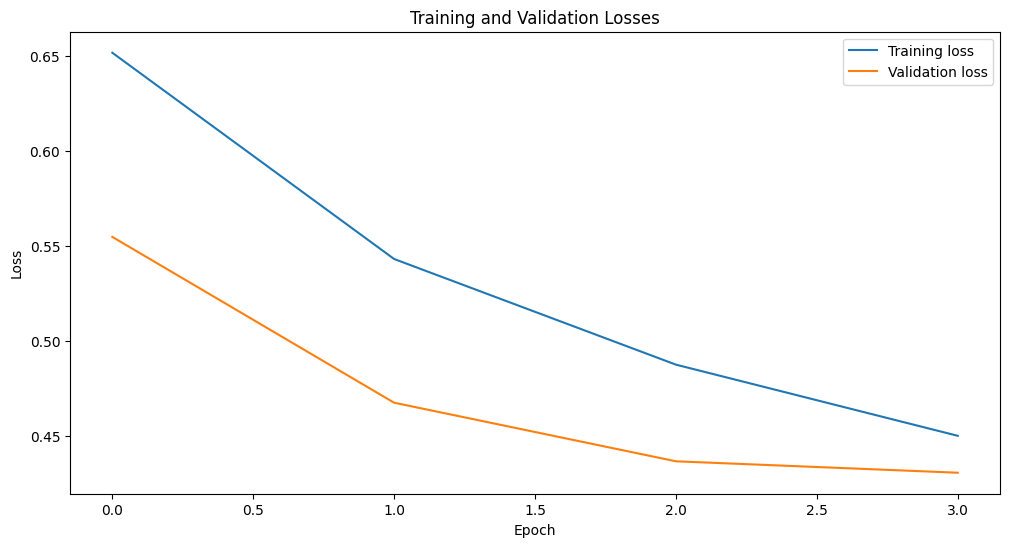

In [69]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=10)
train_and_plot(bert_classifier, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4)
